# Facial Expression Classification

Bayan ALHumaidan - Bayan Alqarni - Aisha Yasir - Shahad Alghofaily - Maitha alqahtani - Sarah Oudah

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
from keras import preprocessing
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import os
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm


# Data import

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d muhammadnafian/kdef-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadnafian/kdef-dataset
License(s): unknown
100% 486M/486M [00:26<00:00, 18.8MB/s]
100% 486M/486M [00:26<00:00, 19.4MB/s]


In [ ]:
!unzip \*.zip && rm *.zip


Archive:  kdef-dataset.zip
  inflating: KDEF/AF01/AF01AFFL.JPG  
  inflating: KDEF/AF01/AF01AFFR.JPG  
  inflating: KDEF/AF01/AF01AFHL.JPG  
  inflating: KDEF/AF01/AF01AFHR.JPG  
  inflating: KDEF/AF01/AF01AFS.JPG   
  inflating: KDEF/AF01/AF01ANFL.JPG  
  inflating: KDEF/AF01/AF01ANFR.JPG  
  inflating: KDEF/AF01/AF01ANHL.JPG  
  inflating: KDEF/AF01/AF01ANHR.JPG  
  inflating: KDEF/AF01/AF01ANS.JPG   
  inflating: KDEF/AF01/AF01DIFL.JPG  
  inflating: KDEF/AF01/AF01DIFR.JPG  
  inflating: KDEF/AF01/AF01DIHL.JPG  
  inflating: KDEF/AF01/AF01DIHR.JPG  
  inflating: KDEF/AF01/AF01DIS.JPG   
  inflating: KDEF/AF01/AF01HAFL.JPG  
  inflating: KDEF/AF01/AF01HAFR.JPG  
  inflating: KDEF/AF01/AF01HAHL.JPG  
  inflating: KDEF/AF01/AF01HAHR.JPG  
  inflating: KDEF/AF01/AF01HAS.JPG   
  inflating: KDEF/AF01/AF01NEFL.JPG  
  inflating: KDEF/AF01/AF01NEFR.JPG  
  inflating: KDEF/AF01/AF01NEHL.JPG  
  inflating: KDEF/AF01/AF01NEHR.JPG  
  inflating: KDEF/AF01/AF01NES.JPG   
  inflating: KDEF/AF01/

# Dataset description

## Organize data

In [ ]:
import os
import cv2

source_directory = '/content/KDEF'
target_directory = '/content/structured_data'

expression_codes = {
    'AF': 'afraid',
    'AN': 'angry',
    'DI': 'disgusted',
    'HA': 'happy',
    'NE': 'neutral',
    'SA': 'sad',
    'SU': 'surprised'
}

# Ensure the target directory exists
if not os.path.exists(target_directory):
    os.makedirs(target_directory)
    print(f"Created target directory: {target_directory}")

def read_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return []
    return [img]

# Function to save images in respective class-based subdirectories
def save_images(images, base_filename, target_folder):
    expression = base_filename[4:6]
    class_folder = os.path.join(target_folder, expression_codes.get(expression, 'unknown'))
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
        print(f"Created class directory: {class_folder}")

    for idx, image in enumerate(images):
        output_path = os.path.join(class_folder, f'{base_filename[:-4]}_{idx}.jpg')
        cv2.imwrite(output_path, image)  # Save in BGR format

for subdir in os.listdir(source_directory):
    subdir_path = os.path.join(source_directory, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            if filename.lower().endswith('.jpg'):
                full_path = os.path.join(subdir_path, filename)
                print(f"Processing file: {full_path}")
                images = read_image(full_path)
                if images:
                    save_images(images, filename, target_directory)


Created target directory: /content/structured_data
Processing file: /content/KDEF/BF26/BF26DIHR.JPG
Created class directory: /content/structured_data/disgusted
Processing file: /content/KDEF/BF26/BF26NEHL.JPG
Created class directory: /content/structured_data/neutral
Processing file: /content/KDEF/BF26/BF26NEFR.JPG
Processing file: /content/KDEF/BF26/BF26ANHR.JPG
Created class directory: /content/structured_data/angry
Processing file: /content/KDEF/BF26/BF26HAHR.JPG
Created class directory: /content/structured_data/happy
Processing file: /content/KDEF/BF26/BF26SUHL.JPG
Created class directory: /content/structured_data/surprised
Processing file: /content/KDEF/BF26/BF26ANFR.JPG
Processing file: /content/KDEF/BF26/BF26ANFL.JPG
Processing file: /content/KDEF/BF26/BF26SUFL.JPG
Processing file: /content/KDEF/BF26/BF26AFFL.JPG
Created class directory: /content/structured_data/afraid
Processing file: /content/KDEF/BF26/BF26HAFL.JPG
Processing file: /content/KDEF/BF26/BF26DIHL.JPG
Processing fil

# Experiment 1: Without face cropping

### Train model without preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.2
)

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

train_generator = train_datagen.flow_from_directory(
    '/content/structured_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    '/content/structured_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=classes_specified
)


Found 3920 images belonging to 7 classes.
Found 978 images belonging to 7 classes.


In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
123/123 [==============================] - 33s 200ms/step - loss: 10.9757 - accuracy: 0.1602 - precision: 0.1893 - recall: 0.0658 - val_loss: 1.9135 - val_accuracy: 0.1779 - val_precision: 0.6538 - val_recall: 0.0174
Epoch 2/50
123/123 [==============================] - 19s 153ms/step - loss: 1.9626 - accuracy: 0.1860 - precision: 0.5080 - recall: 0.0324 - val_loss: 1.8661 - val_accuracy: 0.2229 - val_precision: 0.7059 - val_recall: 0.0245
Epoch 3/50
123/123 [==============================] - 19s 156ms/step - loss: 1.9164 - accuracy: 0.2005 - precision: 0.6235 - recall: 0.0406 - val_loss: 1.8723 - val_accuracy: 0.2249 - val_precision: 0.6607 - val_recall: 0.0378
Epoch 4/50
123/123 [==============================] - 18s 149ms/step - loss: 1.9141 - accuracy: 0.2071 - precision: 0.5814 - recall: 0.0510 - val_loss: 1.8440 - val_accuracy: 0.2178 - val_precision: 0.6667 - val_recall: 0.0429
Epoch 5/50
123/123 [==============================] - 18s 148ms/step - loss: 1.8626 - accur

### without crop: normalization

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

train_generator = train_datagen.flow_from_directory(
    '/content/structured_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    '/content/structured_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=classes_specified
)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
123/123 [==============================] - 20s 154ms/step - loss: 2.4117 - accuracy: 0.1949 - precision: 0.1664 - recall: 0.0224 - val_loss: 1.8366 - val_accuracy: 0.2914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
123/123 [==============================] - 19s 158ms/step - loss: 1.7815 - accuracy: 0.2490 - precision: 0.7356 - recall: 0.0163 - val_loss: 1.6878 - val_accuracy: 0.3988 - val_precision: 0.9412 - val_recall: 0.0164
Epoch 3/50
123/123 [==============================] - 18s 147ms/step - loss: 1.7201 - accuracy: 0.2679 - precision: 0.7550 - recall: 0.0385 - val_loss: 1.6931 - val_accuracy: 0.3507 - val_precision: 0.9333 - val_recall: 0.0143
Epoch 4/50
123/123 [==============================] - 18s 148ms/step - loss: 1.6599 - accuracy: 0.3010 - precision: 0.7356 - recall: 0.0717 - val_loss: 1.4966 - val_accuracy: 0.4836 - val_precision: 0.8246 - val_recall: 0.0481
Epoch 5/50
123/123 [==============================] - 18s 148ms/step - loss: 1.6032 

### without crop: shear.shift.rotate augmetnation

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
root='/content/structured_data'
train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified

)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 3920 images belonging to 7 classes.
Found 978 images belonging to 7 classes.


Epoch 1/50
62/62 [==============================] - 68s 1s/step - loss: 3.1445 - accuracy: 0.1622 - precision: 0.1522 - recall: 0.0286 - val_loss: 1.9350 - val_accuracy: 0.1943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
62/62 [==============================] - 66s 1s/step - loss: 1.9365 - accuracy: 0.1538 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.9188 - val_accuracy: 0.1697 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
62/62 [==============================] - 66s 1s/step - loss: 1.9200 - accuracy: 0.1776 - precision: 0.7000 - recall: 0.0018 - val_loss: 1.8920 - val_accuracy: 0.2096 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
62/62 [==============================] - 65s 1s/step - loss: 1.9062 - accuracy: 0.1778 - precision: 0.6957 - recall: 0.0082 - val_loss: 1.8924 - val_accuracy: 0.1953 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
62/62 [==============================] - 66s 1s/step - loss: 

KeyboardInterrupt: 

### without crop: bight/contrast augmentation

In [ ]:


def apply_color_jitter(image):
    """
    Randomly changes the brightness, contrast, and saturation of an image.
    """
    brightness_range = [0.8, 1.2]
    contrast_range = [0.8, 1.2]

    # Randomly adjust brightness
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
    image = tf.image.adjust_brightness(image, brightness_factor)

    # Randomly adjust contrast
    contrast_factor = np.random.uniform(contrast_range[0], contrast_range[1])
    image = tf.image.adjust_contrast(image, contrast_factor)

    return image
def custom_preprocessing(image):
    """
    Apply both noise and color jitter to the image.
    """
    image = apply_color_jitter(image)
    return image

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=custom_preprocessing,
    rescale=1./255,

)


In [ ]:

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
root='/content/structured_data'
train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified

)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 3920 images belonging to 7 classes.
Found 978 images belonging to 7 classes.


Epoch 1/50
62/62 [==============================] - 42s 662ms/step - loss: 2.7607 - accuracy: 0.2077 - precision: 0.1756 - recall: 0.0352 - val_loss: 1.7667 - val_accuracy: 0.3098 - val_precision: 0.8125 - val_recall: 0.0133
Epoch 2/50
62/62 [==============================] - 40s 651ms/step - loss: 1.7442 - accuracy: 0.2865 - precision: 0.6951 - recall: 0.0291 - val_loss: 1.6487 - val_accuracy: 0.3947 - val_precision: 0.8108 - val_recall: 0.0307
Epoch 3/50
62/62 [==============================] - 40s 652ms/step - loss: 1.6345 - accuracy: 0.3342 - precision: 0.7702 - recall: 0.0607 - val_loss: 1.5424 - val_accuracy: 0.4519 - val_precision: 0.7843 - val_recall: 0.0409
Epoch 4/50
62/62 [==============================] - 40s 651ms/step - loss: 1.5962 - accuracy: 0.3401 - precision: 0.7435 - recall: 0.0880 - val_loss: 1.4907 - val_accuracy: 0.4438 - val_precision: 0.7890 - val_recall: 0.0879
Epoch 5/50
62/62 [==============================] - 40s 652ms/step - loss: 1.4886 - accuracy: 0.3980

### without crop: bight/contrast + noise augmentation

In [ ]:
import numpy as np

def add_random_noise(image):
    """
    Adds random noise to an image.
    """
    noise_factor = 0.5
    noise = np.random.randn(*image.shape) * noise_factor
    image_noisy = image + noise
    return image_noisy

def apply_color_jitter(image):
    """
    Randomly changes the brightness, contrast, and saturation of an image.
    """
    brightness_range = [0.8, 1.2]
    contrast_range = [0.8, 1.2]

    # Randomly adjust brightness
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
    image = tf.image.adjust_brightness(image, brightness_factor)

    # Randomly adjust contrast
    contrast_factor = np.random.uniform(contrast_range[0], contrast_range[1])
    image = tf.image.adjust_contrast(image, contrast_factor)

    return image
def custom_preprocessing(image):
    """
    Apply both noise and color jitter to the image.
    """
    image = apply_color_jitter(image)
    image = add_random_noise(image)
    return image

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=custom_preprocessing,
    rescale=1./255
)


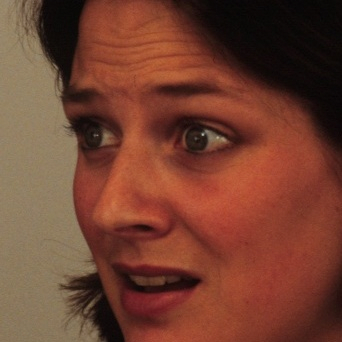

In [ ]:
# prompt: apply custom_preprocessing on image /content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF/afraid/AF01AFHL_0.jpg and plot it using cv2_imshow

import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF/afraid/AF01AFHL_0.jpg'
image = cv2.imread(image_path)

processed_image = add_random_noise(image)

cv2_imshow(processed_image)



In [ ]:
#no cropping with color,noise aug
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
root='/content/structured_data'
train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified

)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 3920 images belonging to 7 classes.
Found 978 images belonging to 7 classes.


Epoch 1/50
62/62 [==============================] - 67s 1s/step - loss: 2.8566 - accuracy: 0.1980 - precision: 0.1812 - recall: 0.0388 - val_loss: 1.7649 - val_accuracy: 0.3088 - val_precision: 0.7778 - val_recall: 0.0215
Epoch 2/50
62/62 [==============================] - 65s 1s/step - loss: 1.7780 - accuracy: 0.2640 - precision: 0.6546 - recall: 0.0324 - val_loss: 1.6363 - val_accuracy: 0.3957 - val_precision: 0.8261 - val_recall: 0.0389
Epoch 3/50
62/62 [==============================] - 65s 1s/step - loss: 1.6392 - accuracy: 0.3349 - precision: 0.7861 - recall: 0.0778 - val_loss: 1.5964 - val_accuracy: 0.4254 - val_precision: 0.9138 - val_recall: 0.0542
Epoch 4/50
62/62 [==============================] - 65s 1s/step - loss: 1.5707 - accuracy: 0.3582 - precision: 0.7633 - recall: 0.1094 - val_loss: 1.3800 - val_accuracy: 0.5112 - val_precision: 0.8472 - val_recall: 0.1247
Epoch 5/50
62/62 [==============================] - 65s 1s/step - loss: 1.4714 - accuracy: 0.4031 - precision: 0

### Gabor filter

In [ ]:
def build_gabor_filters():
    filters = []
    ksize = 31  # Size of the filter
    thetas = np.arange(0, np.pi, np.pi / 4)
    sigmas = [1, 3]
    lambdas = [np.pi / 2, np.pi]
    gammas = [0.05, 0.5]

    for theta in thetas:
        for sigma in sigmas:
            for lamda in lambdas:
                for gamma in gammas:
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    filters.append(kernel)
    return filters

# Initialize Gabor filters globally
gabor_filters = build_gabor_filters()

def apply_selected_gabor_filters(image, filters, selected_indices):
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    responses = []
    for i in selected_indices:
        filtered_img = cv2.filter2D(image, -1, filters[i])
        responses.append(filtered_img)
    stacked_responses = np.stack(responses, axis=-1)
    return stacked_responses

# Assume gabor_filters are already defined and selected_indices are known
# selected_indices = [0, 3, 11, 14, 16, 17, 19, 27, 30] [3,11,17,19,27,30]

selected_indices = [3, 11, 19]

def gabor_preprocessing_function(x):
    # Assuming x is a single image batch from ImageDataGenerator
    # Apply Gabor filters
    return apply_selected_gabor_filters(x, gabor_filters, selected_indices)


In [ ]:
root= '/content/structured_data'
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=gabor_preprocessing_function
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified)

Found 3920 images belonging to 7 classes.
Found 978 images belonging to 7 classes.


In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
62/62 [==============================] - 39s 608ms/step - loss: 2.8911 - accuracy: 0.1783 - precision: 0.1506 - recall: 0.0283 - val_loss: 1.8636 - val_accuracy: 0.2096 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
62/62 [==============================] - 37s 593ms/step - loss: 1.8109 - accuracy: 0.2469 - precision: 0.6961 - recall: 0.0181 - val_loss: 1.7131 - val_accuracy: 0.3548 - val_precision: 0.8000 - val_recall: 0.0082
Epoch 3/50
62/62 [==============================] - 37s 590ms/step - loss: 1.7089 - accuracy: 0.2929 - precision: 0.7553 - recall: 0.0457 - val_loss: 1.6662 - val_accuracy: 0.4479 - val_precision: 0.9333 - val_recall: 0.0143
Epoch 4/50
62/62 [==============================] - 37s 599ms/step - loss: 1.6353 - accuracy: 0.3370 - precision: 0.7473 - recall: 0.0694 - val_loss: 1.5222 - val_accuracy: 0.4397 - val_precision: 0.8280 - val_recall: 0.0787
Epoch 5/50
62/62 [==============================] - 38s 605ms/step - loss: 1.5489 - accuracy

### Two-stage gabor

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
123/123 [==============================] - 37s 255ms/step - loss: 1.9546 - accuracy: 0.2311 - precision: 0.2595 - recall: 0.0122 - val_loss: 1.7473 - val_accuracy: 0.3466 - val_precision: 1.0000 - val_recall: 0.0020
Epoch 2/50
123/123 [==============================] - 31s 252ms/step - loss: 1.6928 - accuracy: 0.3362 - precision: 0.6878 - recall: 0.0360 - val_loss: 1.5880 - val_accuracy: 0.3865 - val_precision: 0.7895 - val_recall: 0.0460
Epoch 3/50
123/123 [==============================] - 31s 249ms/step - loss: 1.5070 - accuracy: 0.4309 - precision: 0.7569 - recall: 0.0985 - val_loss: 1.4506 - val_accuracy: 0.4939 - val_precision: 0.7667 - val_recall: 0.0706
Epoch 4/50
123/123 [==============================] - 31s 252ms/step - loss: 1.3589 - accuracy: 0.5084 - precision: 0.7793 - recall: 0.1630 - val_loss: 1.3562 - val_accuracy: 0.5511 - val_precision: 0.8538 - val_recall: 0.1135
Epoch 5/50
123/123 [==============================] - 31s 250ms/step - loss: 1.2273 - accura

# Haar Cascade face detection crop

### Implement face detection cropping

In [ ]:
# Load the pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

source_directory = '/content/KDEF'
target_directory = '/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF'

expression_codes = {
    'AF': 'afraid',
    'AN': 'angry',
    'DI': 'disgusted',
    'HA': 'happy',
    'NE': 'neutral',
    'SA': 'sad',
    'SU': 'surprised'
}

if not os.path.exists(target_directory):
    os.makedirs(target_directory)
    print(f"Created target directory: {target_directory}")

# Function to apply face detection and cropping
def detect_and_crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    for (x, y, w, h) in faces:
        return img[y:y+h, x:x+w]
    return None

def preprocess_and_augment(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img = detect_and_crop_face(img)
    if cropped_img is None:
        print(f"No face detected in image: {image_path}")
        return []

    if cropped_img.size == 0:
        print(f"Face detection failed or image is too small: {image_path}")
        return []

    processed_images = []
    processed_images.append(cropped_img)

    return processed_images

def save_images(images, base_filename, target_folder):
    expression = base_filename[4:6]
    class_folder = os.path.join(target_folder, expression_codes.get(expression, 'unknown'))
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
        print(f"Created class directory: {class_folder}")

    for idx, image in enumerate(images):
        output_path = os.path.join(class_folder, f'{base_filename[:-4]}_{idx}.jpg')
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

for subdir in os.listdir(source_directory):
    subdir_path = os.path.join(source_directory, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            if filename.lower().endswith('.jpg'):
                full_path = os.path.join(subdir_path, filename)
                print(f"Processing file: {full_path}")
                processed_images = preprocess_and_augment(full_path)
                if processed_images:
                    save_images(processed_images, filename, target_directory)


Streaming output truncated to the last 5000 lines.
Processing file: /content/KDEF/AF11/AF11ANS.JPG
Processing file: /content/KDEF/AF11/AF11SUS.JPG
Processing file: /content/KDEF/AF11/AF11ANFL.JPG
No face detected in image: /content/KDEF/AF11/AF11ANFL.JPG
Processing file: /content/KDEF/AF11/AF11NEFL.JPG
No face detected in image: /content/KDEF/AF11/AF11NEFL.JPG
Processing file: /content/KDEF/AF11/AF11SAHR.JPG
Processing file: /content/KDEF/AF11/AF11HAFL.JPG
No face detected in image: /content/KDEF/AF11/AF11HAFL.JPG
Processing file: /content/KDEF/AF11/AF11SUFL.JPG
No face detected in image: /content/KDEF/AF11/AF11SUFL.JPG
Processing file: /content/KDEF/AF11/AF11NEFR.JPG
No face detected in image: /content/KDEF/AF11/AF11NEFR.JPG
Processing file: /content/KDEF/AF11/AF11DIFR.JPG
No face detected in image: /content/KDEF/AF11/AF11DIFR.JPG
Processing file: /content/KDEF/AF11/AF11NEHR.JPG
Processing file: /content/KDEF/AF11/AF11DIHR.JPG
Processing file: /content/KDEF/AF11/AF11AFHL.JPG
Processin

### Haar: with normalization

In [ ]:
root = '/content/structured_data'
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified

)


Found 2325 images belonging to 7 classes.
Found 579 images belonging to 7 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
37/37 [==============================] - 25s 380ms/step - loss: 3.3698 - accuracy: 0.2800 - precision: 0.2934 - recall: 0.1222 - val_loss: 1.3757 - val_accuracy: 0.4698 - val_precision: 0.8839 - val_recall: 0.1710
Epoch 2/50
37/37 [==============================] - 9s 250ms/step - loss: 1.3476 - accuracy: 0.4834 - precision: 0.7825 - recall: 0.2275 - val_loss: 1.1099 - val_accuracy: 0.6149 - val_precision: 0.9000 - val_recall: 0.2798
Epoch 3/50
37/37 [==============================] - 9s 250ms/step - loss: 1.1637 - accuracy: 0.5643 - precision: 0.8060 - recall: 0.3325 - val_loss: 0.9573 - val_accuracy: 0.6805 - val_precision: 0.8957 - val_recall: 0.4301
Epoch 4/50
37/37 [==============================] - 9s 248ms/step - loss: 1.0312 - accuracy: 0.6138 - precision: 0.8294 - recall: 0.4224 - val_loss: 0.8636 - val_accuracy: 0.7237 - val_precision: 0.8844 - val_recall: 0.4888
Epoch 5/50
37/37 [==============================] - 9s 247ms/step - loss: 0.9579 - accuracy: 0.6383 - p

### Haar: with shear.shift.rotate augmetnation

In [ ]:
#MTNN with augmentation
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
root='/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified
)



Found 2325 images belonging to 7 classes.
Found 579 images belonging to 7 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
37/37 [==============================] - 42s 1s/step - loss: 3.8976 - accuracy: 0.2052 - precision: 0.1898 - recall: 0.0718 - val_loss: 1.7757 - val_accuracy: 0.3523 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 39s 1s/step - loss: 1.7546 - accuracy: 0.3006 - precision: 0.7800 - recall: 0.0335 - val_loss: 1.6261 - val_accuracy: 0.3938 - val_precision: 0.7500 - val_recall: 0.0155
Epoch 3/50
37/37 [==============================] - 39s 1s/step - loss: 1.6945 - accuracy: 0.3114 - precision: 0.6837 - recall: 0.0576 - val_loss: 1.6055 - val_accuracy: 0.4404 - val_precision: 0.7949 - val_recall: 0.0535
Epoch 4/50
37/37 [==============================] - 39s 1s/step - loss: 1.6323 - accuracy: 0.3359 - precision: 0.7390 - recall: 0.1011 - val_loss: 1.4519 - val_accuracy: 0.4991 - val_precision: 0.8961 - val_recall: 0.1192
Epoch 5/50
37/37 [==============================] - 39s 1s/step - loss: 1.5804 - accuracy: 0.3669 - prec

### Haar: with bright/contrast augmetnation

In [ ]:
import numpy as np


def apply_color_jitter(image):
    """
    Randomly changes the brightness, contrast, and saturation of an image.
    """
    brightness_range = [0.7, 0.9]
    contrast_range = [0.7, 0.9]

    # Randomly adjust brightness
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
    image = tf.image.adjust_brightness(image, brightness_factor)

    # Randomly adjust contrast
    contrast_factor = np.random.uniform(contrast_range[0], contrast_range[1])
    image = tf.image.adjust_contrast(image, contrast_factor)

    return image
def custom_preprocessing(image):
    image = apply_color_jitter(image)
    return image

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=custom_preprocessing,
    rescale=1./255
)


In [ ]:
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
root='/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF'
train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified

)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 2325 images belonging to 7 classes.
Found 579 images belonging to 7 classes.


Epoch 1/50
37/37 [==============================] - 19s 491ms/step - loss: 3.7057 - accuracy: 0.2409 - precision: 0.2244 - recall: 0.0942 - val_loss: 1.6208 - val_accuracy: 0.4594 - val_precision: 1.0000 - val_recall: 0.0138
Epoch 2/50
37/37 [==============================] - 17s 469ms/step - loss: 1.5835 - accuracy: 0.4004 - precision: 0.7673 - recall: 0.1049 - val_loss: 1.3940 - val_accuracy: 0.5561 - val_precision: 0.9000 - val_recall: 0.1399
Epoch 3/50
37/37 [==============================] - 18s 480ms/step - loss: 1.3851 - accuracy: 0.4645 - precision: 0.7941 - recall: 0.2073 - val_loss: 1.2451 - val_accuracy: 0.5889 - val_precision: 0.9000 - val_recall: 0.2642
Epoch 4/50
37/37 [==============================] - 18s 490ms/step - loss: 1.2815 - accuracy: 0.5123 - precision: 0.8344 - recall: 0.2688 - val_loss: 1.1192 - val_accuracy: 0.6183 - val_precision: 0.9135 - val_recall: 0.3282
Epoch 5/50
37/37 [==============================] - 18s 477ms/step - loss: 1.1926 - accuracy: 0.5501

### Haar: with bright/contrast + noise augmetnation augmentation

In [ ]:
import numpy as np

def add_random_noise(image):
    """
    Adds random noise to an image.
    """
    noise_factor = 0.1
    noise = np.random.randn(*image.shape) * noise_factor
    image_noisy = image + noise
    # image_noisy = np.clip(image_noisy, 0., 1.)
    return image_noisy

def apply_color_jitter(image):
    """
    Randomly changes the brightness, contrast, and saturation of an image.
    """
    brightness_range = [0.8, 1.2]
    contrast_range = [0.8, 1.2]

    # Randomly adjust brightness
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
    image = tf.image.adjust_brightness(image, brightness_factor)

    # Randomly adjust contrast
    contrast_factor = np.random.uniform(contrast_range[0], contrast_range[1])
    image = tf.image.adjust_contrast(image, contrast_factor)

    return image
def custom_preprocessing(image):
    image = apply_color_jitter(image)
    image = add_random_noise(image)
    return image

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=custom_preprocessing,
    rescale=1./255
)


In [ ]:
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
root='/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF'
train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified

)


Found 2325 images belonging to 7 classes.
Found 579 images belonging to 7 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
37/37 [==============================] - 35s 911ms/step - loss: 3.1341 - accuracy: 0.2925 - precision: 0.3093 - recall: 0.1402 - val_loss: 1.3878 - val_accuracy: 0.4870 - val_precision: 0.8533 - val_recall: 0.2211
Epoch 2/50
37/37 [==============================] - 33s 901ms/step - loss: 1.3447 - accuracy: 0.4787 - precision: 0.7507 - recall: 0.2241 - val_loss: 1.1202 - val_accuracy: 0.6546 - val_precision: 0.9454 - val_recall: 0.2988
Epoch 3/50
37/37 [==============================] - 33s 920ms/step - loss: 1.1984 - accuracy: 0.5441 - precision: 0.7794 - recall: 0.3131 - val_loss: 1.0050 - val_accuracy: 0.6304 - val_precision: 0.8667 - val_recall: 0.4491
Epoch 4/50
37/37 [==============================] - 33s 893ms/step - loss: 1.0529 - accuracy: 0.6060 - precision: 0.8428 - recall: 0.4034 - val_loss: 0.9241 - val_accuracy: 0.6805 - val_precision: 0.8734 - val_recall: 0.4646
Epoch 5/50
37/37 [==============================] - 33s 909ms/step - loss: 0.9537 - accuracy: 0.6348

### Haar: Gabor filter

In [ ]:
def build_gabor_filters():
    filters = []
    ksize = 31
    thetas = np.arange(0, np.pi, np.pi / 4)
    sigmas = [1, 3]
    lambdas = [np.pi / 2, np.pi]
    gammas = [0.05, 0.5]

    for theta in thetas:
        for sigma in sigmas:
            for lamda in lambdas:
                for gamma in gammas:
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    filters.append(kernel)
    return filters

gabor_filters = build_gabor_filters()


In [ ]:
import numpy as np
import cv2
import os

def evaluate_filter_effectiveness(directory, filters):
    response_statistics = {i: [] for i in range(len(filters))}

    if os.path.isfile(directory):
        image_paths = [directory]
    else:
        image_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))  # Resize to the expected input size

        for i, filter_kernel in enumerate(filters):
            response = cv2.filter2D(image, -1, filter_kernel)
            response_statistics[i].append(np.var(response))  # Collect variance of the response

    # Calculate average variance for each filter across all images
    average_variances = {i: np.mean(vars) for i, vars in response_statistics.items()}

    # Select filters based on a variance threshold or the top N filters
    threshold = np.mean(list(average_variances.values()))  # Example threshold
    selected_filters = {i: var for i, var in average_variances.items() if var > threshold}

    return selected_filters

selected_filters = evaluate_filter_effectiveness('/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF/afraid', gabor_filters)
print("Selected filter indices based on variance:", selected_filters)


Selected filter indices based on variance: {0: 2503.503981072739, 1: 1109.2437376183523, 2: 1127.3036004039031, 3: 3471.8189756951397, 11: 3412.4750679818785, 14: 1793.424578177385, 16: 2148.232007059935, 17: 1089.643980112904, 19: 3431.064501841601, 27: 3410.5568717971382, 30: 1798.9556881243248}


In [ ]:
def apply_selected_gabor_filters(image, filters, selected_indices):
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    responses = []
    for i in selected_indices:
        filtered_img = cv2.filter2D(image, -1, filters[i])
        responses.append(filtered_img)
    stacked_responses = np.stack(responses, axis=-1)
    return stacked_responses

# Assume gabor_filters are already defined and selected_indices are known
# selected_indices = [0, 3, 11, 14, 16, 17, 19, 27, 30] [3,11,17,19,27,30]

selected_indices = [3, 11, 19]

def gabor_preprocessing_function(x):
    # Assuming x is a single image batch from ImageDataGenerator
    # Apply Gabor filters
    return apply_selected_gabor_filters(x, gabor_filters, selected_indices)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
root='/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF'

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']


train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=gabor_preprocessing_function,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    classes=classes_specified

)


Found 2325 images belonging to 7 classes.
Found 579 images belonging to 7 classes.


In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
73/73 [==============================] - 24s 302ms/step - loss: 2.7850 - accuracy: 0.3092 - precision: 0.3241 - recall: 0.1101 - val_loss: 1.2920 - val_accuracy: 0.6218 - val_precision: 0.9670 - val_recall: 0.1520
Epoch 2/50
73/73 [==============================] - 22s 297ms/step - loss: 1.3066 - accuracy: 0.4976 - precision: 0.7722 - recall: 0.2654 - val_loss: 1.0717 - val_accuracy: 0.6753 - val_precision: 0.9336 - val_recall: 0.3402
Epoch 3/50
73/73 [==============================] - 22s 296ms/step - loss: 1.1337 - accuracy: 0.5733 - precision: 0.8002 - recall: 0.3806 - val_loss: 0.9593 - val_accuracy: 0.6528 - val_precision: 0.8386 - val_recall: 0.4577
Epoch 4/50
73/73 [==============================] - 22s 298ms/step - loss: 1.0224 - accuracy: 0.6172 - precision: 0.8044 - recall: 0.4439 - val_loss: 0.8411 - val_accuracy: 0.7098 - val_precision: 0.8986 - val_recall: 0.5354
Epoch 5/50
73/73 [==============================] - 22s 297ms/step - loss: 0.9257 - accuracy: 0.6426

### Haar: two-stage gabor filter

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np

def build_gabor_kernel(ksize=31, sigma=1.5, theta=np.pi / 4, lamda=5, gamma=1.5, psi=0, ktype=cv2.CV_32F):
    """
    Build a single Gabor filter kernel.
    """
    return cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, psi, ktype)

# Build Gabor kernels once
gabor_kernel1 = build_gabor_kernel()
gabor_kernel2 = build_gabor_kernel(theta=3 * np.pi / 4)

def apply_two_stage_gabor_filters(image, kernel1, kernel2):
    """
    Apply two Gabor filters sequentially to an image and return the processed image.
    Assumes image is in grayscale or converts it if necessary.
    """
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.filter2D(image, -1, kernel1)
    image = cv2.filter2D(image, -1, kernel2)

    return image

def gabor_preprocessing_function(image):
    """
    Adapt the image format for use with Keras' ImageDataGenerator, ensuring three-channel output.
    """
    processed_image = apply_two_stage_gabor_filters(image, gabor_kernel1, gabor_kernel2)
    # Stack the grayscale image across three channels
    processed_image = np.stack((processed_image,)*3, axis=-1)
    return processed_image


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
root='/content/drive/MyDrive/Colab Data/Image/haaar_cropped_KDEF'

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']


train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=gabor_preprocessing_function,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    classes=classes_specified

)


Found 2325 images belonging to 7 classes.
Found 579 images belonging to 7 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
73/73 [==============================] - 20s 258ms/step - loss: 1.7269 - accuracy: 0.3381 - precision: 0.5683 - recall: 0.1019 - val_loss: 1.3355 - val_accuracy: 0.5095 - val_precision: 0.9146 - val_recall: 0.1295
Epoch 2/50
73/73 [==============================] - 18s 247ms/step - loss: 1.1798 - accuracy: 0.5712 - precision: 0.8058 - recall: 0.3355 - val_loss: 1.0280 - val_accuracy: 0.6667 - val_precision: 0.8862 - val_recall: 0.3765
Epoch 3/50
73/73 [==============================] - 18s 244ms/step - loss: 0.9469 - accuracy: 0.6723 - precision: 0.8426 - recall: 0.5019 - val_loss: 0.8843 - val_accuracy: 0.7237 - val_precision: 0.8807 - val_recall: 0.4974
Epoch 4/50
73/73 [==============================] - 18s 247ms/step - loss: 0.7901 - accuracy: 0.7187 - precision: 0.8802 - recall: 0.5785 - val_loss: 0.8419 - val_accuracy: 0.7133 - val_precision: 0.8491 - val_recall: 0.5734
Epoch 5/50
73/73 [==============================] - 18s 246ms/step - loss: 0.6736 - accuracy: 0.7785

# MTNN face detection cropping

### implement face detection cropping

In [ ]:
!pip install mtcnn


In [ ]:
from mtcnn import MTCNN
from tqdm import tqdm

def crop_single_face(filename):
    image = cv2.imread(filename)
    if image is None:
        print(f"The image at {filename} could not be read.")
        return None

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    faces = detector.detect_faces(rgb_image)

    if len(faces) != 1:
        print(f"No face or more than one face detected in: {filename}")
        return None

    x, y, width, height = faces[0]['box']
    x, y = max(x, 0), max(y, 0)
    cropped_face = rgb_image[y:y+height, x:x+width]
    cropped_face_bgr = cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR)
    return cropped_face_bgr

def save_image(image, filename, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
        print(f"Created directory: {target_folder}")
    cv2.imwrite(filename, image)
    print(f"Saved {filename}")

source_directory = '/content/KDEF'
target_directory = '/content/mtnn_cropped_1'

expression_codes = {
    'AF': 'afraid',
    'AN': 'angry',
    'DI': 'disgusted',
    'HA': 'happy',
    'NE': 'neutral',
    'SA': 'sad',
    'SU': 'surprised'
}

for subdir in tqdm(os.listdir(source_directory), desc="Processing directories"):
    subdir_path = os.path.join(source_directory, subdir)
    if os.path.isdir(subdir_path):
        files = os.listdir(subdir_path)
        for filename in tqdm(files, desc=f"Processing images in {subdir}", leave=False):
            if filename.lower().endswith('.jpg'):
                full_path = os.path.join(subdir_path, filename)
                cropped_image = crop_single_face(full_path)
                if cropped_image is not None:
                    expression = filename[4:6]
                    class_folder = os.path.join(target_directory, expression_codes.get(expression, 'unknown'))
                    save_image(cropped_image, os.path.join(class_folder, filename), class_folder)


### MTNN: Fit model without preprocessing

In [ ]:
root = '/content/mtnn_cropped_1'
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

train_datagen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 3875 images belonging to 7 classes.
Found 965 images belonging to 7 classes.


Epoch 1/50
61/61 [==============================] - 23s 355ms/step - loss: 11.8974 - accuracy: 0.2759 - precision: 0.3323 - recall: 0.1649 - val_loss: 1.6536 - val_accuracy: 0.3503 - val_precision: 0.8347 - val_recall: 0.1047
Epoch 2/50
61/61 [==============================] - 15s 250ms/step - loss: 1.6112 - accuracy: 0.3835 - precision: 0.6806 - recall: 0.1935 - val_loss: 1.3220 - val_accuracy: 0.4912 - val_precision: 0.7912 - val_recall: 0.2238
Epoch 3/50
61/61 [==============================] - 15s 250ms/step - loss: 1.3936 - accuracy: 0.4465 - precision: 0.7175 - recall: 0.2924 - val_loss: 1.1686 - val_accuracy: 0.5461 - val_precision: 0.8814 - val_recall: 0.2694
Epoch 4/50
61/61 [==============================] - 15s 250ms/step - loss: 1.2888 - accuracy: 0.4893 - precision: 0.7164 - recall: 0.3332 - val_loss: 1.1076 - val_accuracy: 0.5731 - val_precision: 0.8152 - val_recall: 0.3337
Epoch 5/50
61/61 [==============================] - 15s 249ms/step - loss: 1.1742 - accuracy: 0.524

### MTNN: With normalization

In [ ]:
root = '/content/mtnn_cropped_1'
classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified

)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified

)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 3875 images belonging to 7 classes.
Found 965 images belonging to 7 classes.


Epoch 1/50
61/61 [==============================] - 17s 257ms/step - loss: 2.4978 - accuracy: 0.3321 - precision: 0.3875 - recall: 0.1071 - val_loss: 1.3233 - val_accuracy: 0.5233 - val_precision: 0.8947 - val_recall: 0.1762
Epoch 2/50
61/61 [==============================] - 15s 251ms/step - loss: 1.2702 - accuracy: 0.5249 - precision: 0.7846 - recall: 0.2501 - val_loss: 1.0360 - val_accuracy: 0.6601 - val_precision: 0.8723 - val_recall: 0.3326
Epoch 3/50
61/61 [==============================] - 15s 250ms/step - loss: 1.1106 - accuracy: 0.5814 - precision: 0.7747 - recall: 0.3461 - val_loss: 0.9526 - val_accuracy: 0.6611 - val_precision: 0.8226 - val_recall: 0.4611
Epoch 4/50
61/61 [==============================] - 15s 250ms/step - loss: 0.9855 - accuracy: 0.6317 - precision: 0.8024 - recall: 0.4297 - val_loss: 0.8793 - val_accuracy: 0.6902 - val_precision: 0.9008 - val_recall: 0.4425
Epoch 5/50
61/61 [==============================] - 15s 250ms/step - loss: 0.9219 - accuracy: 0.6485

### MTNN: with shift/shear/rotate augmentation

In [ ]:
#MTNN with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

root='/content/mtnn_cropped_1/mtnn_cropped_1'

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training' ,
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation' ,
    classes=classes_specified
)



Found 3875 images belonging to 7 classes.
Found 965 images belonging to 7 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
61/61 [==============================] - 63s 1s/step - loss: 2.5917 - accuracy: 0.1889 - precision: 0.1604 - recall: 0.0263 - val_loss: 1.7812 - val_accuracy: 0.2290 - val_precision: 0.6667 - val_recall: 0.0041
Epoch 2/50
61/61 [==============================] - 56s 911ms/step - loss: 1.7680 - accuracy: 0.2643 - precision: 0.7344 - recall: 0.0243 - val_loss: 1.6908 - val_accuracy: 0.3368 - val_precision: 0.7667 - val_recall: 0.0238
Epoch 3/50
61/61 [==============================] - 56s 913ms/step - loss: 1.7028 - accuracy: 0.2970 - precision: 0.6923 - recall: 0.0511 - val_loss: 1.5705 - val_accuracy: 0.4197 - val_precision: 0.8305 - val_recall: 0.0508
Epoch 4/50
61/61 [==============================] - 55s 905ms/step - loss: 1.6133 - accuracy: 0.3293 - precision: 0.7383 - recall: 0.0895 - val_loss: 1.5430 - val_accuracy: 0.3741 - val_precision: 0.7634 - val_recall: 0.1036
Epoch 5/50
61/61 [==============================] - 56s 911ms/step - loss: 1.6258 - accuracy: 0.3143 - 

### MTNN: Gabor filter

In [ ]:
import numpy as np
import cv2
import os

def evaluate_filter_effectiveness(directory, filters):
    response_statistics = {i: [] for i in range(len(filters))}

    if os.path.isfile(directory):
        image_paths = [directory]
    else:
        image_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))  # Resize to the expected input size

        for i, filter_kernel in enumerate(filters):
            response = cv2.filter2D(image, -1, filter_kernel)
            response_statistics[i].append(np.var(response))  # Collect variance of the response

    # Calculate average variance for each filter across all images
    average_variances = {i: np.mean(vars) for i, vars in response_statistics.items()}

    # Select filters based on a variance threshold or the top N filters
    threshold = np.mean(list(average_variances.values()))  # Example threshold
    selected_filters = {i: var for i, var in average_variances.items() if var > threshold}

    return selected_filters

# Assuming gabor_filters are already defined and built
selected_filters = evaluate_filter_effectiveness('/content/mtnn_cropped_1/disgusted', gabor_filters)
print("Selected filter indices based on variance:", selected_filters)


Selected filter indices based on variance: {0: 2228.14765289577, 1: 1038.9192270011179, 2: 936.6102187070267, 3: 3325.150048472212, 11: 3357.9237672133963, 14: 1875.9033084043265, 16: 2480.800589788589, 17: 1123.0997494825542, 18: 969.2319719282165, 19: 3470.188262605657, 27: 3361.5478899001628, 30: 1892.5446716506708}


In [ ]:
def build_gabor_filters():
    filters = []
    ksize = 31  # Size of the filter
    thetas = np.arange(0, np.pi, np.pi / 4)
    sigmas = [1, 3]
    lambdas = [np.pi / 2, np.pi]
    gammas = [0.05, 0.5]

    for theta in thetas:
        for sigma in sigmas:
            for lamda in lambdas:
                for gamma in gammas:
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    filters.append(kernel)
    return filters

# Initialize Gabor filters globally
gabor_filters = build_gabor_filters()


In [ ]:
def apply_selected_gabor_filters(image, filters, selected_indices):
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    responses = []
    for i in selected_indices:
        filtered_img = cv2.filter2D(image, -1, filters[i])
        responses.append(filtered_img)
    stacked_responses = np.stack(responses, axis=-1)
    return stacked_responses

# selected_indices = [0, 3, 11, 14, 16, 17, 19, 27, 30] [3,11,17,19,27,30]

selected_indices = [3, 11, 19]

def gabor_preprocessing_function(x):
    # Assuming x is a single image batch from ImageDataGenerator
    # Apply Gabor filters
    return apply_selected_gabor_filters(x, gabor_filters, selected_indices)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
root='/content/mtnn_cropped_1'

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']


train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=gabor_preprocessing_function,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    classes=classes_specified

)


Found 3875 images belonging to 7 classes.
Found 965 images belonging to 7 classes.


In [ ]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
122/122 [==============================] - 28s 221ms/step - loss: 2.1917 - accuracy: 0.3275 - precision: 0.3897 - recall: 0.0880 - val_loss: 1.3064 - val_accuracy: 0.5751 - val_precision: 0.9204 - val_recall: 0.1078
Epoch 2/50
122/122 [==============================] - 27s 218ms/step - loss: 1.3202 - accuracy: 0.4792 - precision: 0.7285 - recall: 0.2382 - val_loss: 1.0174 - val_accuracy: 0.6570 - val_precision: 0.8653 - val_recall: 0.3596
Epoch 3/50
122/122 [==============================] - 27s 220ms/step - loss: 1.1421 - accuracy: 0.5564 - precision: 0.7482 - recall: 0.3443 - val_loss: 0.9431 - val_accuracy: 0.7192 - val_precision: 0.8915 - val_recall: 0.3917
Epoch 4/50
122/122 [==============================] - 27s 222ms/step - loss: 1.0426 - accuracy: 0.5915 - precision: 0.7646 - recall: 0.4065 - val_loss: 0.8458 - val_accuracy: 0.7565 - val_precision: 0.8970 - val_recall: 0.4601
Epoch 5/50
122/122 [==============================] - 27s 218ms/step - loss: 0.9916 - accura

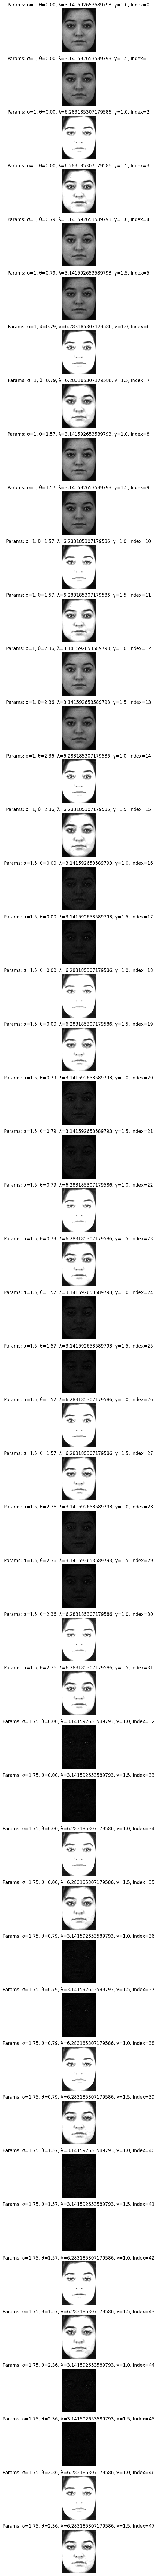

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Updated parameters in the Gabor filter function
def build_gabor_filters(ksize=31, sigmas=None, thetas=None, lambdas=None, gammas=None, psi=0, ktype=cv2.CV_32F):
    filters = []
    params_list = []
    sigmas = sigmas if sigmas is not None else [1, 1.5, 1.75]
    thetas = thetas if thetas is not None else [0, np.pi/4, np.pi/2, 3*np.pi/4]
    lambdas = lambdas if lambdas is not None else [np.pi, np.pi * 2]
    gammas = gammas if gammas is not None else [1.0, 1.5]

    for sigma in sigmas:
        for theta in thetas:
            for lamda in lambdas:
                for gamma in gammas:
                    params = (sigma, theta, lamda, gamma, psi, ksize, ktype)
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, psi, ktype)
                    filters.append(kernel)
                    params_list.append(params)
    return filters, params_list

def visualize_gabor_filters(filters, params_list, image):
    fig, axs = plt.subplots(nrows=len(filters), figsize=(5, 2 * len(filters)))
    if len(filters) == 1:
        axs = [axs]  # Make it iterable if there's only one subplot
    for ax, kernel, params in zip(axs, filters, params_list):
        filtered_img = cv2.filter2D(image, -1, kernel)
        ax.imshow(filtered_img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Params: σ={params[0]}, θ={params[1]:.2f}, λ={params[2]}, γ={params[3]}, Index={params_list.index(params)}")
    plt.tight_layout()
    plt.show()

# Load image
img = cv2.imread('/content/mtnn_cropped_1/neutral/AF03NES.JPG', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found or path is incorrect")

# Generate filters and their parameters
gabor_filters, params_list = build_gabor_filters()

# Visualize each filter's effect on the image along with the parameters
visualize_gabor_filters(gabor_filters, params_list, img)


### MTNN: two-stage gabor

In [ ]:

def build_gabor_kernel(ksize=31, sigma=1.5, theta=np.pi / 4, lamda=5, gamma=1.5, psi=0, ktype=cv2.CV_32F):
    """
    Build a single Gabor filter kernel.
    """
    return cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, psi, ktype)

# Build Gabor kernels once
gabor_kernel1 = build_gabor_kernel()
gabor_kernel2 = build_gabor_kernel(theta=3 * np.pi / 4)

def apply_two_stage_gabor_filters(image, kernel1, kernel2):
    """
    Apply two Gabor filters sequentially to an image and return the processed image.
    Assumes image is in grayscale or converts it if necessary.
    """
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.filter2D(image, -1, kernel1)
    image = cv2.filter2D(image, -1, kernel2)

    return image

def gabor_preprocessing_function(image):
    """
    Adapt the image format for use with Keras' ImageDataGenerator, ensuring three-channel output.
    """
    processed_image = apply_two_stage_gabor_filters(image, gabor_kernel1, gabor_kernel2)
    # Stack the grayscale image across three channels
    processed_image = np.stack((processed_image,)*3, axis=-1)
    return processed_image


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
root='/content/mtnn_cropped_1'

classes_specified = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']


train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=gabor_preprocessing_function,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes_specified
)

validation_generator = train_datagen.flow_from_directory(
    root,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    classes=classes_specified

)


Found 3875 images belonging to 7 classes.
Found 965 images belonging to 7 classes.


In [ ]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes_specified), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/50
122/122 [==============================] - 23s 180ms/step - loss: 1.6654 - accuracy: 0.3719 - precision: 0.6303 - recall: 0.0968 - val_loss: 1.1772 - val_accuracy: 0.6218 - val_precision: 0.8945 - val_recall: 0.2021
Epoch 2/50
122/122 [==============================] - 21s 173ms/step - loss: 1.1267 - accuracy: 0.5912 - precision: 0.7889 - recall: 0.3337 - val_loss: 0.9756 - val_accuracy: 0.6684 - val_precision: 0.8589 - val_recall: 0.3720
Epoch 3/50
122/122 [==============================] - 21s 174ms/step - loss: 0.8847 - accuracy: 0.6815 - precision: 0.8302 - recall: 0.4908 - val_loss: 0.8481 - val_accuracy: 0.7150 - val_precision: 0.8229 - val_recall: 0.5295
Epoch 4/50
122/122 [==============================] - 21s 173ms/step - loss: 0.7305 - accuracy: 0.7440 - precision: 0.8550 - recall: 0.6041 - val_loss: 0.7278 - val_accuracy: 0.7472 - val_precision: 0.8569 - val_recall: 0.5959
Epoch 5/50
122/122 [==============================] - 21s 175ms/step - loss: 0.6222 - accura